# Project 3 Hassan Alam
## Goal:
Deveop framework for Multi-Variate Time Series Forecast

## Sections

Section 1: Import All Libraries<br>
Section 2: Import Alpaca Data<br>
Section 3: NewsAPI<br>
Section 4: Get Tones from IBM<br>
Section 5: Integrate data<br>
Section 6: LSTM<br>
Section 7: Dashboard<br>


## Notes - to delete
1. v 1.0 All cells working.<br>
2. v 1.1 Move LSTM to end<br>
3. v 1.1.1. new sequence working<br>
4. v 1.1.2. updated to add Section 5 in the middle for integrating all data<br>
5. v 1.1.3 fixed in news sentiment api take info from news API<br>
6. v 1.1.4 need to  combine price data with sentiment data<br>
7. v 1.1.5 test lstm with combinded ata. - working<br>
8. v 1.1.6 working version of lSTM <br>
9. v 1.1.7 alpaca imported<br>
10. v 1.1.8 end to end test<br>
11. v 1.1.9 clean up unwanted cells<br>
12. v 1.2.0 cleaned up end to end<br>
13. v 1.2.1 Initial attempt a panel to display matplotlib does not separate charts for panel
14. v 1.2.2 Do panel by converting values to dataframe and then using plotly express with panel
15  v 1.2.3 Clean final code

##  <span style="color:red">Section 1: Import All Libraries

In [1]:
import alpaca_trade_api as tradeapi
import json
import numpy as np
import os
import pandas as pd
import requests

from datetime import datetime, date, timedelta
# from datetime import date
from dotenv import load_dotenv
from ibm_watson import ToneAnalyzerV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from keras.models import Sequential
from keras.layers import Dense, LSTM
# from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from newsapi import NewsApiClient
from numpy import concatenate
# from numpy import concatenate
from pandas import read_csv, DataFrame, concat
# from pandas import DataFrame
# from pandas import concat
from pandas.io.json import json_normalize
# import pandas as pd
from pandas import read_csv
from pathlib import Path
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error


%matplotlib inline
load_dotenv('test1.env')


Bad key "text.kerning_factor" on line 4 in
C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


True

##  <span style="color:red">Section 2: Import Alpaca Data

### Section 2.1 TBD
Import last one month from Alpacaa based on stock.<br>
Function global variable that is stock.

In [4]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")
# type(alpaca_secret_key)

In [5]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

In [6]:
def get_alapa_prices (in_tick_list, 
                      alpaca_api_key: str, 
                      alpaca_secret_key: str, 
                      in_start_date: str, in_end_date= ""):
    '''get asset price list from AlPaca
    
    Args:
        in_tick_list(list): list of tickers in the form of string
        ALPACA_API_KEY(str): from you alpaca account
        ALPACA_SECRET_KEY(str): from your alpaca account
        in_start_date(str): in the form 'yyyy-mm-dd'
        in_end_date (str): optional. Will set today as default
        
    Returns:
        DataFrame: a two index DataFrame 
            first index ticker symol from in_tick_list
            second index: open, high, low, close, volume
    
    '''
    # set up alpaca
    api = tradeapi.REST(
        alpaca_api_key,
        alpaca_secret_key,
        api_version = "v2"
        )  
    
    #set up dates
    start_date = pd.Timestamp(in_start_date, tz="America/New_York").isoformat()
    if in_end_date != '': #'if not blank'
        end_date = pd.Timestamp(in_end_date, tz="America/New_York").isoformat()
    else:
        end_date = date.today().strftime("%Y-%m-%d")

       
    #  break up into chunks for 100
    n = 100
    tic_lists = [in_tick_list[i:i + n] for i in range(0, len(in_tick_list), n)]  
        
    #loop through tickers 
    comb_df = pd.DataFrame()
    timeframe = "1D"
    for tickers in tic_lists:
        #get in batches of 100
        df_ticker = api.get_barset(
            tickers,
            timeframe,
            start=start_date,
            end=end_date,
            limit=1000,
            ).df 
        comb_df = pd.concat( [comb_df, df_ticker], axis = 1)
        
    return comb_df

In [7]:
def extrct_close(in_df):
    '''extract dataframe single index and close prices
    
    Args:
        in_df(DataFrame): Dataframe of stock prices from get_alapa_prices

        
    Returns:
        DataFrame: single column index with ticker symbol as column lables 
            first index ticker symol from in_tick_list
            second index: open, high, low, close, volume
    
    ''' 
    df_close = pd.DataFrame()
    tickers = list(in_df.columns.levels[0])
    for cur_tick in tickers:
        df_close[cur_tick] = in_df [cur_tick]['close']
        
    return df_close

In [8]:
# not used
def return_stats (in_df):
    '''create data frame of stats of daily returns
    
    Args:
        in_df(DataFrame): Dataframe of closing stock prices

        
    Returns:
        DataFrame: return data from of daily returns 
    
    ''' 
 
    df_pct_chgn = in_df.pct_change() #get daily percentage change
    df_stats = pd.DataFrame() #create stats dataframe
    df_stats = df_pct_chgn.skew().to_frame() #add skew
    df_stats.columns = ['skew'] #rename  column
    df_stats['mean'] = df_pct_chgn.mean() #add mean
    df_stats['std'] = df_pct_chgn.std() #add std dev
    return df_stats
    

In [9]:
from_date = (date.today()- timedelta(30)).strftime("%Y-%m-%d")
to_date = date.today().strftime("%Y-%m-%d")
stock_list = ['GOOG']

In [10]:
df_stock_prices = get_alapa_prices(stock_list, alpaca_api_key, alpaca_secret_key, from_date )
df_close = extrct_close(df_stock_prices)
df_stats = return_stats(df_close)
# df_stats.sample(5)
# df_close.head(2)

### Section 2.2 
Currently reads file. Need to put in Alpaca

### 2.x Do pct change

### 2.x Do Fraction and log change

In [11]:
df_close.shift().head(5)
df_change = df_close/df_close.shift()
df_log_change = np.log(df_close/df_close.shift())
# df_log_change.head(2)
raw_df = df_log_change

### 2.x select sub setion of columns

2. xx Change index to day

In [12]:
date_index_df = raw_df.copy()
# test.index = pd.to_datetime(test.index, format = '%Y-%m-%d')
date_index_df.index = date_index_df.index.strftime('%Y-%m-%d')
# date_index_df.head(2)
date_index_df.dropna(inplace = True, how = 'all')
# date_index_df.head(2)

## <span style="color:red">Section 3: NewsAPI

### 3.1. 
1. parameterize topic for query
2. current system only does last 30 days.. once code is done download last 3 years to get test data on all stocks
3. Need to synchronize with stock time data
4. delete all oil info

In [194]:
# from newsapi import NewsApiClient

In [13]:
# Create a newsapi client
api_key = os.getenv("news_api")
newsapi = NewsApiClient(api_key=api_key)

In [14]:
# can only get 30 days of data without paid accoutn
# set start date to 30 days ago
from_date = (date.today()- timedelta(30)).strftime("%Y-%m-%d")
#set endate as today
to_date = date.today().strftime("%Y-%m-%d")
# this is current topic. parameterize this
query = "google"
all_articles = newsapi.get_everything(q=query,language='en',
        sort_by='relevancy',from_param=from_date,to=to_date)

In [15]:
def sort_news (in_news):
    '''
    loop through artiles in news api and sort by date.
    create data frame 
    one dataframe with full content
    second with text and date only
    '''
    #convert articles to dataframe
    art_df = pd.DataFrame.from_dict(all_articles['articles'])
    #change to a date string
#     df['age']=df.apply(lambda x: x['age']+3,axis=1)
    # create a column text that concats title descripiton and content
    art_df ['text'] = art_df['title'] + " " + art_df['description'] + " " + art_df['content']
    art_df['date'] = art_df['publishedAt'].apply (lambda x: x[:10])
    #sort by date
    art_df.sort_values (by=['date'], inplace = True)
    #concat all text by date
    text_df = art_df.groupby('date')['text'].apply (lambda x: ','.join (x)).reset_index()
    return art_df, text_df
    
    

In [198]:
art_df, text_df = sort_news(all_articles)
# text_df.head(5)

In [199]:
test_text = text_df.copy()
test_text.set_index('date', drop = True, inplace = True)
# test_text.head()

#### 3.2.2 combine data with news and and convert NA text to ''


In [200]:
news_price = pd.concat([date_index_df, test_text], axis = 1, join = "outer")
news_price['text'] = news_price['text'].fillna(value = 'no items in news today ' + query)
# news_price.tail(20)

C:\Users\Hassan\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## <span style="color:red">Section 4: Get Tones from IBM

4.1 Read the Keys

In [201]:
# Get the Tone Analyzer API Key and URL
# todo make into function
tone_api = os.getenv("TONE_ANALYZER_APIKEY")
tone_url = os.getenv("TONE_ANALYZER_URL")

4.2 Initiaze IBM

In [202]:
def init_ibm():
    '''
    code to initialize IBM netork
    '''
    #load environment
    load_dotenv('ibm-credentials.env')
    # Initialize Tone Analyser Client

    # Create authentication object
    authenticator = IAMAuthenticator(tone_api)

    # Create tone_analyzer instance
    tone_analyzer = ToneAnalyzerV3(
        version="2017-09-21",
        authenticator=authenticator                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
    )

    # Set the service endpoint
    tone_analyzer.set_service_url(tone_url)
    return tone_analyzer

4.3 Function to create tone for each line of text and create a series<br>
todo handle if there is no tone

In [203]:
def create_tone_series(in_text):
    '''
    Takes a text and generates a series of tones based on tonlist
    need to make sure IBM network is alived
    in_text = text to be analzye
    in_tn = tone analyzer
    
    '''
    #set error variabes
    sent_tone = False
    doc_tone = False
    
    #analzye the doe
    tone_analysis = tone_analyzer.tone(
        {"text": in_text},
        content_type="application/json",
        content_language="en",
        accept_language="en",
    ).get_result()
    
    # debug
    #print (f'in_text: {in_text}\n')
    # print (f'json dumpgs {json.dumps(tone_analysis, indent=2)}\n')
 
    #define list of tones
    tone_list = ['excited', 'frustrated','impolite', 'polite', 'sad', 'satisfied', 'sympathetic', 
             'anger', 'disgust', 'fear', 'joy', 'sadness',
            'analytical', 'confident', 'tentative',
            'openness_big5', 'conscientiousness_big5', 'extraversion_big5', 'agreeableness_big5',  'emotional_range_big5']
    #create tone df with all zeros
    zero_df = pd.DataFrame(0, index=np.arange(1), columns=tone_list)
    
    #create sentence tone df
    # check if there is a sensettone, then put 
    try:
        sentences_tone_df = json_normalize(
            data=tone_analysis["sentences_tone"],
            record_path=["tones"],
            meta=["sentence_id", "text"],
            )
        if not(sentences_tone_df.empty):
            sent_tone = True
        
    except:
        set_tone = False
    
    #change it to a dataframe
    try:
        doc_tone_df = json_normalize(data=tone_analysis["document_tone"], record_path=["tones"])
        #debug 
         #print (f'doc_tone_df is true: {doc_tone_df}\n')
        if not(doc_tone_df.empty):
            doc_tone = True
    except:
        doc_tone = False
        
    
    #creae summary fo all tones
    # debug print (f'sent_done: {sent_tone}\n')
    # debug print (f'doc_tone: {doc_tone}\n')
    if sent_tone:
        tsp_df = sentences_tone_df.groupby('tone_id').sum().transpose()
    elif doc_tone:
        tsp_df = doc_tone_df.groupby('tone_id').sum().transpose()
    else:
        # blank
        return zero_df.iloc[0]

    

    #replace falues from tone_df
    zero_df [tsp_df.columns] = tsp_df[tsp_df.columns].values
       
    # debug print (f'zero_df[0]: {zero_df.iloc[0]}\n')  

    return zero_df.iloc[0]

In [206]:
# test_df = sentences_tone_df.copy()

tone_list = ['excited', 'frustrated','impolite', 'polite', 'sad', 'satisfied', 'sympathetic', 
             'anger', 'disgust', 'fear', 'joy', 'sadness',
            'analytical', 'confident', 'tentative',
            'openness_big5', 'conscientiousness_big5', 'extraversion_big5', 'agreeableness_big5',  'emotional_range_big5']
tone_analyzer = init_ibm()

In [207]:
# main set to attach tones to dataframe

test_df = news_price.copy()

test_df[tone_list] = test_df['text'].apply(lambda x: create_tone_series(x))
# test_df.insert(1, tone_list) = test_df['text'].apply(lambda x: create_tone_series(x))



## <span style="color:red">Section 5 Combine Data

In [208]:
# reindext  by combining list
# tone columns + original columns
new_column_order = tone_list + news_price.columns.to_list() 

# delete these line
# columnsTitles = ['onething', 'secondthing', 'otherthing']
# frame = frame.reindex(columns=columnsTitles)
LSTM_input_df = test_df.copy()
LSTM_input_df = LSTM_input_df.reindex (columns = new_column_order)
# drop the text column
LSTM_input_df.drop('text', 1, inplace = True)
# new_df = new_df []
# LSTM_input_df.head (1)

## <span style="color:red">Section 6: LSTM</span>.

### 6.1 Notes
1. it takes raw df, change to a fucntion
2. imports on top may not be necessary or should be pulled into top
3. Make into a function

### 6.x create chart of actual vs predicted
1. remove all items called and change raw df to log 

In [ ]:
# from math import sqrt
# from numpy import concatenate
# from matplotlib import pyplot
# from pandas import read_csv
# from pandas import DataFrame
# from pandas import concat
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import mean_squared_error
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
# dataset = read_csv('pollution.csv', header=0, index_col=0)
# dataset = raw_df
# dataset = date_index_df
dataset = LSTM_input_df
values = dataset.values
# integer encode direction

# take this out
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')
# normalize features

# debug
# print (f'value shape: {values.shape}') #debug

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict

# redo this secttion
# reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
## num_col_to_drop = lstm_input.shape[1] - scaled_data.shape[1]
#### drop the columns at the end
## lstm_input = lstm_input.iloc[:, : - num_col_to_drop]

#above 
#calculate the number of columns to drop
num_col_to_drop =  reframed.shape[1] - dataset.shape[1] -1
# drop the clast columns
reframed = reframed.iloc[:, : -num_col_to_drop]
# print (f'reframe shape: {reframed.shape}')
#

# print(reframed.head())
 
# split into train and test sets
values = reframed.values

# redo this section
# n_train_hours = 365 * 24
# train = values[:n_train_hours, :]
# test = values[n_train_hours:, :]

# redone here
# set test_fraction (set it to 0.7)
test_fract = 0.7
split = int(test_fract * len(values))
train = values[:split, :]
test = values [split:, :]


# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

# print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
# change verbose to zo
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=0, shuffle=False)

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)

# debug
print (f'inv_y shape: {inv_yhat.shape}')

inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [257]:
# delte
# pred_vs_actual():
# pyplot.plot (np.exp(inv_yhat), label='predicted')
# pyplot.plot (np.exp(LSTM_input_df['GOOG'][-6:]), label='actual')
# pyplot.legend()
# pyplot.show()

In [256]:
# delete
# plot_lstm():
# pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='test')
# pyplot.legend()
# pyplot.show()

In [ ]:
# delete
# np.exp(inv_yhat)
# LSTM_input_df['GOOG'][-6:]

In [222]:
# for change - do not keep
test1_df = LSTM_input_df.copy()
test1_df['change'] = test1_df['GOOG'].apply (lambda x: 1 if x > 0 else -1)
test1_df.head(2)

,excited,frustrated,impolite,polite,sad,satisfied,sympathetic,anger,disgust,fear,...,analytical,confident,tentative,openness_big5,conscientiousness_big5,extraversion_big5,agreeableness_big5,emotional_range_big5,GOOG,change
2021-08-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.822231,0.0,0.0,0.0,0.0,0.0,0.001833,1
2021-08-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,-0.002032,-1


In [241]:
pred=pd.DataFrame(inv_yhat, columns = ['pred_val'])
pred['change'] = pred['pred_val'].apply (lambda x: 1 if x > 0 else -1)
pred

,pred_val,change
0,0.011841,1
1,0.004305,1
2,0.014793,1
3,-0.008704,-1
4,0.010319,1
5,0.001379,1


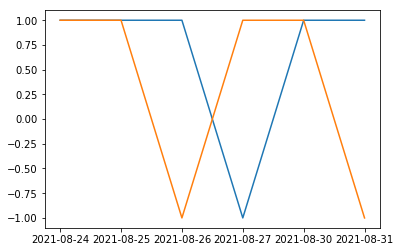

In [242]:
pyplot.plot (pred['change'])
pyplot.plot (test1_df['change'][-6:])
pyplot.show()

## Section 7 Dashboard

In [252]:
# initial imports
# move to intiialization
import pandas as pd
import numpy as np
from pathlib import Path
import panel as pn
from panel.interact import interact
import plotly.express as px
pn.extension("plotly")

C:\Users\Hassan\Anaconda3\envs\pyvizenv\lib\site-packages\xarray\core\merge.py:10: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


### 7.1 Create dataframes for the plots

#### 7.1.1 Data from for prediction

In [395]:
pred_df = pd.DataFrame(np.exp(inv_yhat), columns = ['predicted'])
actuals_df = np.exp(LSTM_input_df['GOOG'][-6:]).to_frame()
pred_df = pd.concat([pred_df, actuals_df.reset_index()], axis = 1)
pred_df.set_index ('index' ,inplace = True)
pred_df.columns = ['predicted', 'actual']

#### 7.1.1 Data from for LSTM performance

In [396]:
# LSTM_df = pd.DataFrame(history.history['loss'], columns = ['Loss'])
train_ser = history.history['loss']
test_ser = history.history['val_loss']
lstm_dict = {'train': train_ser, 'test':test_ser}
lstm_df = pd.DataFrame(lstm_dict)


### 7.3 Create Plotly Express Objects

In [409]:
lstm_plot = px.line(lstm_df, width=1000)
pred_plot = px.line (pred_df, width=1000)

### 7.3 Plot them

In [410]:
tabs = pn.Tabs(
    ('lstm',lstm_plot),
    ('pred', pred_plot)
#     ("Statistical Plots", row_of_parallel)
)
tabs

Tabs
    [0] Plotly(Figure, name='lstm')
    [1] Plotly(Figure, name='pred')